In [1]:
import numpy as np
from scipy.stats import expon
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from label_shift import BaseExperiment, ImportanceWeightExperiment

In [2]:
LEARNING_RATE = 0.01
MOMENTUM = 0.9
BATCH_SIZE = 32
NUM_EPOCHS = 50

In [3]:
class LogisticRegression(tf.keras.Model):
    def __init__(self, n_classes, l2_lambda=0.0):
        super().__init__()
        self.dense = tf.keras.layers.Dense(
            n_classes,
            kernel_initializer=tf.keras.initializers.RandomNormal(),
            kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)
        )

    def call(self, inputs, training=None):
        x = self.dense(inputs)
        x = tf.nn.softmax(x)
        return x

In [4]:
def preprocess(example):
    return tf.reshape(example['image']/255, [-1]), example['label']

train_dataset = tfds.load('mnist', split='train').map(preprocess).shuffle(1024).batch(BATCH_SIZE)
test_dataset = tfds.load('mnist', split='test').map(preprocess).batch(BATCH_SIZE)

Epoch 0
Train Loss=0.4181188941001892, Train Accuracy=0.8842499852180481
Test Loss=0.31170564889907837, Test Accuracy=0.9129999876022339
Epoch 1
Train Loss=0.31390446424484253, Train Accuracy=0.9118833541870117
Test Loss=0.29599061608314514, Test Accuracy=0.9168000221252441
Epoch 2
Train Loss=0.29690003395080566, Train Accuracy=0.916266679763794
Test Loss=0.2832789123058319, Test Accuracy=0.921500027179718
Epoch 3
Train Loss=0.2881476581096649, Train Accuracy=0.9195333123207092
Test Loss=0.28010323643684387, Test Accuracy=0.9204000234603882
Epoch 4
Train Loss=0.28188303112983704, Train Accuracy=0.9208666682243347
Test Loss=0.27863332629203796, Test Accuracy=0.920799970626831
Epoch 5
Train Loss=0.2777979373931885, Train Accuracy=0.9224666953086853
Test Loss=0.27710530161857605, Test Accuracy=0.9197999835014343
Epoch 6
Train Loss=0.2742398977279663, Train Accuracy=0.9232500195503235
Test Loss=0.2740817666053772, Test Accuracy=0.9218000173568726
Epoch 7
Train Loss=0.2714008688926697, Trai

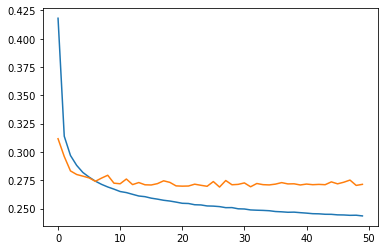

In [5]:
experiment = BaseExperiment(
    LogisticRegression(10), 
    tf.keras.losses.SparseCategoricalCrossentropy(),
    tf.keras.optimizers.SGD(LEARNING_RATE, MOMENTUM)
)
experiment.train(train_dataset, test_dataset, NUM_EPOCHS)
    
plt.plot(experiment.history['train_loss'])
plt.plot(experiment.history['test_loss'])

In [6]:
def resample_dataset(dataset, density, training=False):
    all_inputs = []
    all_labels = []
    resampled_inputs = []
    resampled_labels = []
    
    for inputs, labels in dataset:
        all_inputs.append(inputs)
        all_labels.append(labels)
        
    all_inputs = np.vstack(all_inputs)
    all_labels = np.hstack(all_labels)
    
    for digit, p_digit in enumerate(density):
        print(f'{digit}: {p_digit}')
        index = np.where(all_labels == digit)[0]
        index = index[:int(len(index)*p_digit)]
        resampled_inputs.append(all_inputs[index])
        resampled_labels.append(all_labels[index])
        
    dataset = tf.data.Dataset.from_tensor_slices(
        (np.vstack(resampled_inputs), np.hstack(resampled_labels))
    )

    if training:
        return dataset.shuffle(1024).batch(BATCH_SIZE)
    else:
        return dataset.batch(BATCH_SIZE)

density, _ = np.histogram(expon.rvs(scale=1/0.5, size=1000), bins=range(11), density=True)
train_density = np.random.permutation(density)
test_density = np.random.permutation(density)

resampled_train_dataset = resample_dataset(train_dataset, train_density, training=True)
stationary_test_dataset = resample_dataset(test_dataset, train_density, training=False)
shifted_test_dataset = resample_dataset(test_dataset, test_density, training=False)

0: 0.3717434869739479
1: 0.05911823647294589
2: 0.004008016032064128
3: 0.01503006012024048
4: 0.014028056112224449
5: 0.008016032064128256
6: 0.0871743486973948
7: 0.1713426853707415
8: 0.02404809619238477
9: 0.24549098196392785
0: 0.3717434869739479
1: 0.05911823647294589
2: 0.004008016032064128
3: 0.01503006012024048
4: 0.014028056112224449
5: 0.008016032064128256
6: 0.0871743486973948
7: 0.1713426853707415
8: 0.02404809619238477
9: 0.24549098196392785
0: 0.004008016032064128
1: 0.3717434869739479
2: 0.02404809619238477
3: 0.01503006012024048
4: 0.24549098196392785
5: 0.008016032064128256
6: 0.0871743486973948
7: 0.1713426853707415
8: 0.014028056112224449
9: 0.05911823647294589


# Exponentially resampled MNIST with stationary train/test

Epoch 0
Train Loss=0.6534772515296936, Train Accuracy=0.8328908085823059
Test Loss=0.40046894550323486, Test Accuracy=0.890890896320343
Epoch 1
Train Loss=0.27441883087158203, Train Accuracy=0.9221705794334412
Test Loss=0.3399864435195923, Test Accuracy=0.9039039015769958
Epoch 2
Train Loss=0.22508074343204498, Train Accuracy=0.933786928653717
Test Loss=0.34009721875190735, Test Accuracy=0.8948948979377747
Epoch 3
Train Loss=0.20405448973178864, Train Accuracy=0.9384334683418274
Test Loss=0.26435723900794983, Test Accuracy=0.9179179072380066
Epoch 4
Train Loss=0.18957456946372986, Train Accuracy=0.9414204955101013
Test Loss=0.2836391031742096, Test Accuracy=0.9099099040031433
Epoch 5
Train Loss=0.18272432684898376, Train Accuracy=0.9434118866920471
Test Loss=0.24546734988689423, Test Accuracy=0.9299299120903015
Epoch 6
Train Loss=0.1685435026884079, Train Accuracy=0.9498838186264038
Test Loss=0.26017576456069946, Test Accuracy=0.9179179072380066
Epoch 7
Train Loss=0.16338486969470978, 

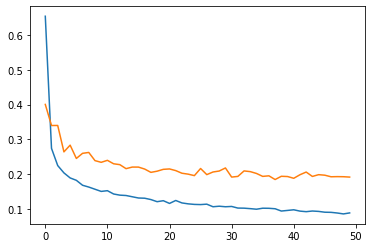

In [7]:
experiment = BaseExperiment(
    LogisticRegression(10), 
    tf.keras.losses.SparseCategoricalCrossentropy(),
    tf.keras.optimizers.SGD(LEARNING_RATE, MOMENTUM)
)
experiment.train(resampled_train_dataset, stationary_test_dataset, NUM_EPOCHS)
    
plt.plot(experiment.history['train_loss'])
plt.plot(experiment.history['test_loss'])


# Exponentially resampled MNIST with shifted train/test

Epoch 0
Train Loss=0.625374972820282, Train Accuracy=0.8435114622116089
Test Loss=1.7172516584396362, Test Accuracy=0.6372360587120056
Epoch 1
Train Loss=0.2805781960487366, Train Accuracy=0.9190176129341125
Test Loss=1.2586411237716675, Test Accuracy=0.6641075015068054
Epoch 2
Train Loss=0.2203548550605774, Train Accuracy=0.9344506859779358
Test Loss=1.2476327419281006, Test Accuracy=0.6727447509765625
Epoch 3
Train Loss=0.2056625336408615, Train Accuracy=0.9361101984977722
Test Loss=0.9770917296409607, Test Accuracy=0.6861804127693176
Epoch 4
Train Loss=0.18915997445583344, Train Accuracy=0.9409226775169373
Test Loss=1.09482741355896, Test Accuracy=0.691938579082489
Epoch 5
Train Loss=0.17751124501228333, Train Accuracy=0.946398913860321
Test Loss=0.8805037140846252, Test Accuracy=0.7120921015739441
Epoch 6
Train Loss=0.16293840110301971, Train Accuracy=0.9508795142173767
Test Loss=0.9251357913017273, Test Accuracy=0.7178502678871155
Epoch 7
Train Loss=0.16273316740989685, Train Accu

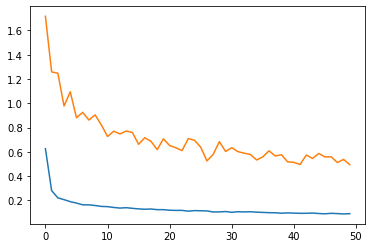

In [8]:
experiment = BaseExperiment(
    LogisticRegression(10), 
    tf.keras.losses.SparseCategoricalCrossentropy(),
    tf.keras.optimizers.SGD(LEARNING_RATE, MOMENTUM)
)
experiment.train(resampled_train_dataset, shifted_test_dataset, NUM_EPOCHS)
    
plt.plot(experiment.history['train_loss'])
plt.plot(experiment.history['test_loss'])

# Importance weights

### Oracle

Epoch 0
Train Loss=0.8977192044258118, Train Accuracy=0.6085296869277954
Test Loss=0.5448279976844788, Test Accuracy=0.841650664806366
Epoch 1
Train Loss=0.2749558389186859, Train Accuracy=0.5891138315200806
Test Loss=0.44609731435775757, Test Accuracy=0.8560460805892944
Epoch 2
Train Loss=0.24193209409713745, Train Accuracy=0.6926651000976562
Test Loss=0.35143452882766724, Test Accuracy=0.8742802143096924
Epoch 3
Train Loss=0.17388004064559937, Train Accuracy=0.7701626420021057
Test Loss=0.43430495262145996, Test Accuracy=0.8589251637458801
Epoch 4
Train Loss=0.19307081401348114, Train Accuracy=0.7726518511772156
Test Loss=0.25932347774505615, Test Accuracy=0.9184260964393616
Epoch 5
Train Loss=0.15500032901763916, Train Accuracy=0.8211085200309753
Test Loss=0.371349960565567, Test Accuracy=0.8771592974662781
Epoch 6
Train Loss=0.1537693738937378, Train Accuracy=0.824095606803894
Test Loss=0.27567216753959656, Test Accuracy=0.9184260964393616
Epoch 7
Train Loss=0.13016846776008606, Tr

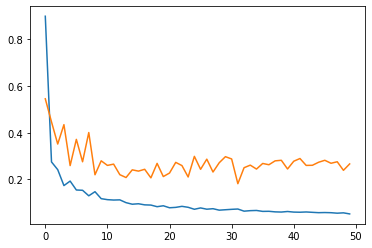

In [9]:
importance_weights = test_density / train_density
importance_weights = importance_weights / np.sum(importance_weights)
importance_weights = importance_weights.astype(np.float32)

experiment = ImportanceWeightExperiment(
    LogisticRegression(10), 
    tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE),
    tf.keras.optimizers.SGD(LEARNING_RATE, MOMENTUM),
    importance_weights
)
experiment.train(resampled_train_dataset, shifted_test_dataset, NUM_EPOCHS)
    
plt.plot(experiment.history['train_loss'])
plt.plot(experiment.history['test_loss'])

### Lipton et al. (2018)

In [10]:
def confusion_matrix(model, dataset):
    all_labels = []
    all_predictions = []

    for inputs, labels in dataset:
        outputs = model(inputs, training=False)
        all_labels.append(labels)
        all_predictions.append(tf.argmax(outputs, axis=1))
    
    return tf.math.confusion_matrix(
        np.hstack(all_labels), np.hstack(all_predictions)
    )

